<a href="https://colab.research.google.com/github/stwind/notebooks/blob/master/style_transfer_vanilla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uq torchinfo

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import io
import os
import math
import time
import random
import copy
import requests
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import PIL
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as tfms
import torchvision.models as models
import tensorflow as tf
import moviepy.editor as mvp
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torchvision.utils import make_grid
from torchinfo import summary
from fastprogress.fastprogress import progress_bar
from matplotlib.gridspec import GridSpec
from IPython.display import Image, HTML, clear_output
from moviepy.editor import VideoClip

os.environ['FFMPEG_BINARY'] = 'ffmpeg'

sns.set('notebook', 'darkgrid', rc={
    'font.family': ['DejaVu Sans'],
    'font.sans-serif': ['Open Sans', 'Arial Unicode MS'],
    'font.size': 12,
    'figure.figsize': (8, 5),
    'grid.linewidth': 1,
    'grid.alpha': 0.5,
    'legend.fontsize': 10,
    'legend.frameon': True,
    'legend.framealpha': 0.6,
    'legend.handletextpad': 0.2,
    'lines.linewidth': 1,
    'axes.facecolor': '#fafafa',
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'axes.linewidth': 0.5,
    'xtick.labelsize': 11,
    'xtick.major.width': 0.5,
    'ytick.labelsize': 11,
    'ytick.major.width': 0.5,
    'figure.titlesize': 13,
})
plt.style.use("dark_background")

print("Infos:")
print("numpy: {}".format(np.__version__))
print("seaborn: {}".format(sns.__version__))
print("matplotlib: {}".format(mpl.__version__))
print("pytorch: {}".format(torch.__version__))
for i in range(torch.cuda.device_count()):
    print("cuda device #{}: {}".format(i, torch.cuda.get_device_name(i)))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("current device type: {}".format(device.type))

Infos:
numpy: 1.19.5
seaborn: 0.11.1
matplotlib: 3.2.2
pytorch: 1.7.0+cu101
cuda device #0: Tesla T4
current device type: cuda


## Utils

In [4]:
def fetch_image(url, size=None, mode=None):
    if url.startswith(('http:', 'https:')):
        r = requests.get(url)
        f = io.BytesIO(r.content)
    else:
        f = url
    img = PIL.Image.open(f)
    if size is not None:
        img.thumbnail((size, size), PIL.Image.ANTIALIAS)
    if mode is not None:
        img = img.convert(mode)
    return img

def imshow(img, figsize=(5,5), title=None, cmap=None):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

## Data

In [5]:
urls = {
    "kandinsky": "https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg",
    "goldengate": "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0c/GoldenGateBridge-001.jpg/1024px-GoldenGateBridge-001.jpg"
}

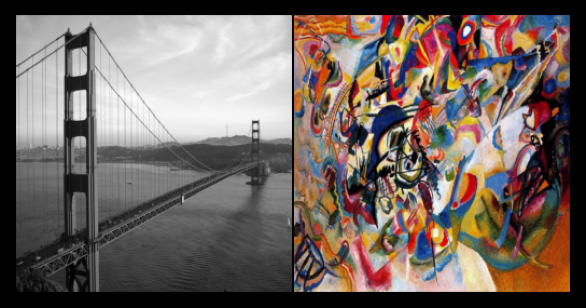

In [27]:
content_image = fetch_image(urls["goldengate"], mode="L")
style_image = fetch_image(urls["kandinsky"])

size = 256


MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])
normalize = tfms.Normalize(MEAN, STD)
denormalize = tfms.Normalize(-MEAN / STD, 1 / STD)
transform = tfms.Compose([tfms.Resize((size, size)), tfms.ToTensor()])

content_img = transform(content_image).repeat(1,3,1,1).to(device)
style_img = transform(style_image).unsqueeze(0).to(device)

imshow(make_grid(torch.cat([content_img,style_img]).cpu()).permute(1,2,0).numpy())

## Model

In [23]:
vgg19 = models.vgg19(pretrained=True).features.eval().to(device)

In [35]:
def gram_matrix(x):
    h, w = x.shape[-2:]
    x = x.clone()
    return torch.einsum('bchw, bdhw -> bcd', x, x) / (h * w)


content_layers = [7]
style_layers = [0, 2, 5, 7, 10]


content_losses = []
style_losses = []

x_content, x_style = normalize(content_img), normalize(style_img)

for i, layer in enumerate(vgg19[:max(content_layers + style_layers) + 1]):
    x_content, x_style = layer(x_content), layer(x_style)

    if i in content_layers:
        content_losses.append(x_content.detach().clone())

    if i in style_layers:
        style_losses.append(gram_matrix(x_style.detach()))

In [36]:
input_param = torch.rand_like(content_img).requires_grad_(True)
optimizer = torch.optim.Adam([input_param], lr=1e-2, weight_decay=1e-6)

epochs = 2001

for epoch in progress_bar(range(epochs)):

    x = normalize(input_param.clip(0, 1))
    c_losses, s_losses = [], []
    
    for i, layer in enumerate(vgg19):
        x = layer(x)

        if i in content_layers:
            c_losses.append(x.clone())

        if i in style_layers:
            s_losses.append(gram_matrix(x))

    content_loss = 0.0
    for a, b in zip(c_losses, content_losses):
        content_loss += F.mse_loss(a, b)

    style_loss = 0.0
    for a, b in zip(s_losses, style_losses):
        style_loss += F.mse_loss(a, b)

    optimizer.zero_grad()
    loss = content_loss + style_loss * 0.15
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print('[{}/{}] Style Loss : {:4f} Content Loss: {:4f}'.format(
            epoch, epochs, content_loss.item(), style_loss.item()))

[0/2001] Style Loss : 127.172470 Content Loss: 47277.921875
[100/2001] Style Loss : 58.476318 Content Loss: 207.553268
[200/2001] Style Loss : 54.268959 Content Loss: 114.574112
[300/2001] Style Loss : 50.590164 Content Loss: 85.428909
[400/2001] Style Loss : 47.536861 Content Loss: 70.559341
[500/2001] Style Loss : 45.088173 Content Loss: 61.554436
[600/2001] Style Loss : 43.087082 Content Loss: 55.444057
[700/2001] Style Loss : 41.427586 Content Loss: 50.935383
[800/2001] Style Loss : 40.026665 Content Loss: 47.463200
[900/2001] Style Loss : 38.798714 Content Loss: 44.681870
[1000/2001] Style Loss : 37.702263 Content Loss: 42.459412
[1100/2001] Style Loss : 36.710758 Content Loss: 40.627594
[1200/2001] Style Loss : 35.831665 Content Loss: 39.118809
[1300/2001] Style Loss : 35.059681 Content Loss: 37.848400
[1400/2001] Style Loss : 34.372917 Content Loss: 36.767532
[1500/2001] Style Loss : 33.759689 Content Loss: 35.840775
[1600/2001] Style Loss : 33.202011 Content Loss: 35.070385
[17

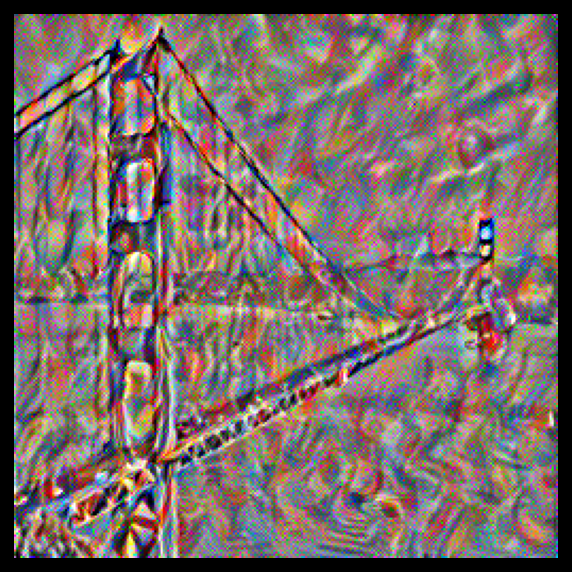

In [37]:
imshow(input_param.detach().cpu().squeeze().permute(1,2,0).numpy().clip(0,1))